# Convolutional Neural Network
### We use PyTorch libraries to train our own CNN using the CIFAR-10 dataset


###1. Importing the necessary libraries


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import os
os.makedirs('outdir', exist_ok=True)

###2. Loading of the CIFAR-10 dataset


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:13<00:00, 13034857.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###3. Definition of the CNN model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

###4. Training of dataset

In [4]:
net = Net()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
total_step = len(trainloader)
train_loss = []
train_acc = []
val_loss = []
val_acc = []
predicted_labels = []
true_labels = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
correct_total = 0
total_total = 0

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    total_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==labels).item()
        total += labels.size(0)

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    train_acc.append(100 * correct / total)
    train_loss.append(total_loss/total_step)

    batch_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            #images, labels = data
            images, labels = data[0].cuda(), data[1].cuda()
            outputs = net(images)
            loss_test = criterion(outputs, labels)
            batch_loss += loss_test.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            total_total += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            correct_total += (predicted == labels).sum().item()
            _, pred = torch.max(outputs, 1)
            c = (pred == labels).squeeze()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

        val_acc.append(100 * correct_test / total_test)
        val_loss.append(batch_loss/len(testloader))


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.868
[1,  6000] loss: 1.686
[1,  8000] loss: 1.588
[1, 10000] loss: 1.525
[1, 12000] loss: 1.481
[2,  2000] loss: 1.411
[2,  4000] loss: 1.387
[2,  6000] loss: 1.359
[2,  8000] loss: 1.341
[2, 10000] loss: 1.305
[2, 12000] loss: 1.292
[3,  2000] loss: 1.209
[3,  4000] loss: 1.236
[3,  6000] loss: 1.196
[3,  8000] loss: 1.178
[3, 10000] loss: 1.193
[3, 12000] loss: 1.172
[4,  2000] loss: 1.091
[4,  4000] loss: 1.108
[4,  6000] loss: 1.111
[4,  8000] loss: 1.086
[4, 10000] loss: 1.088
[4, 12000] loss: 1.086
[5,  2000] loss: 1.001
[5,  4000] loss: 1.019
[5,  6000] loss: 1.027
[5,  8000] loss: 1.035
[5, 10000] loss: 0.997
[5, 12000] loss: 1.024
[6,  2000] loss: 0.923
[6,  4000] loss: 0.955
[6,  6000] loss: 0.959
[6,  8000] loss: 0.949
[6, 10000] loss: 0.971
[6, 12000] loss: 0.973
[7,  2000] loss: 0.888
[7,  4000] loss: 0.891
[7,  6000] loss: 0.914
[7,  8000] loss: 0.915
[7, 10000] loss: 0.924
[7, 12000] loss: 0.916
[8,  2000] loss: 0.829
[8,  4000] 

###5. Print the accuracy statistics

In [5]:
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_test / total_test))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 63 %
Accuracy of plane : 66 %
Accuracy of   car : 72 %
Accuracy of  bird : 48 %
Accuracy of   cat : 38 %
Accuracy of  deer : 53 %
Accuracy of   dog : 50 %
Accuracy of  frog : 67 %
Accuracy of horse : 64 %
Accuracy of  ship : 71 %
Accuracy of truck : 64 %


###6. Print the accuracy and loss curve

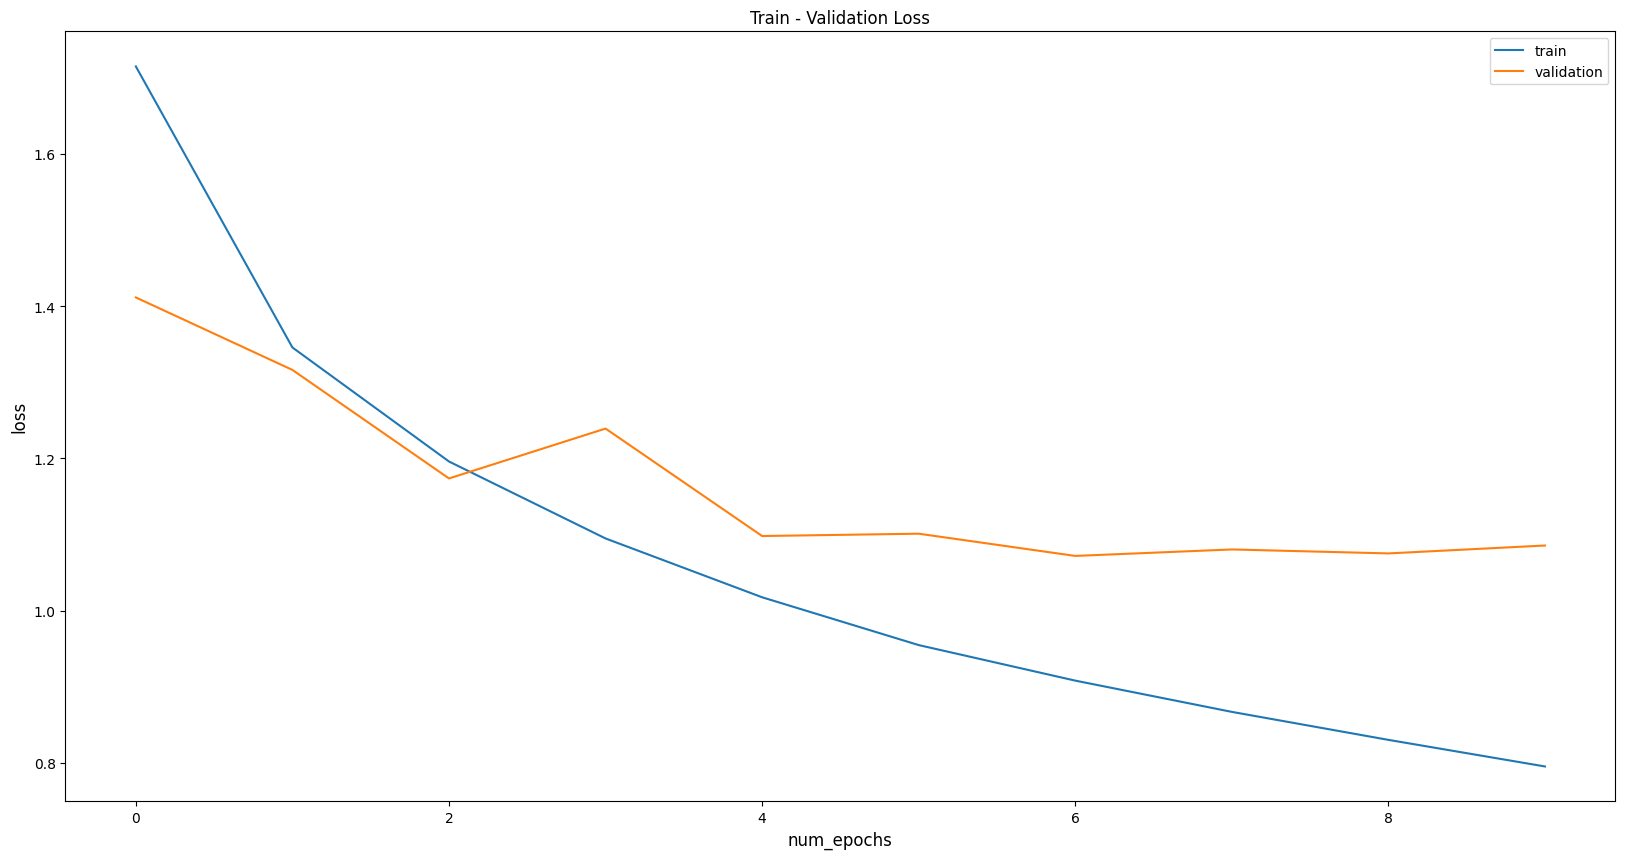

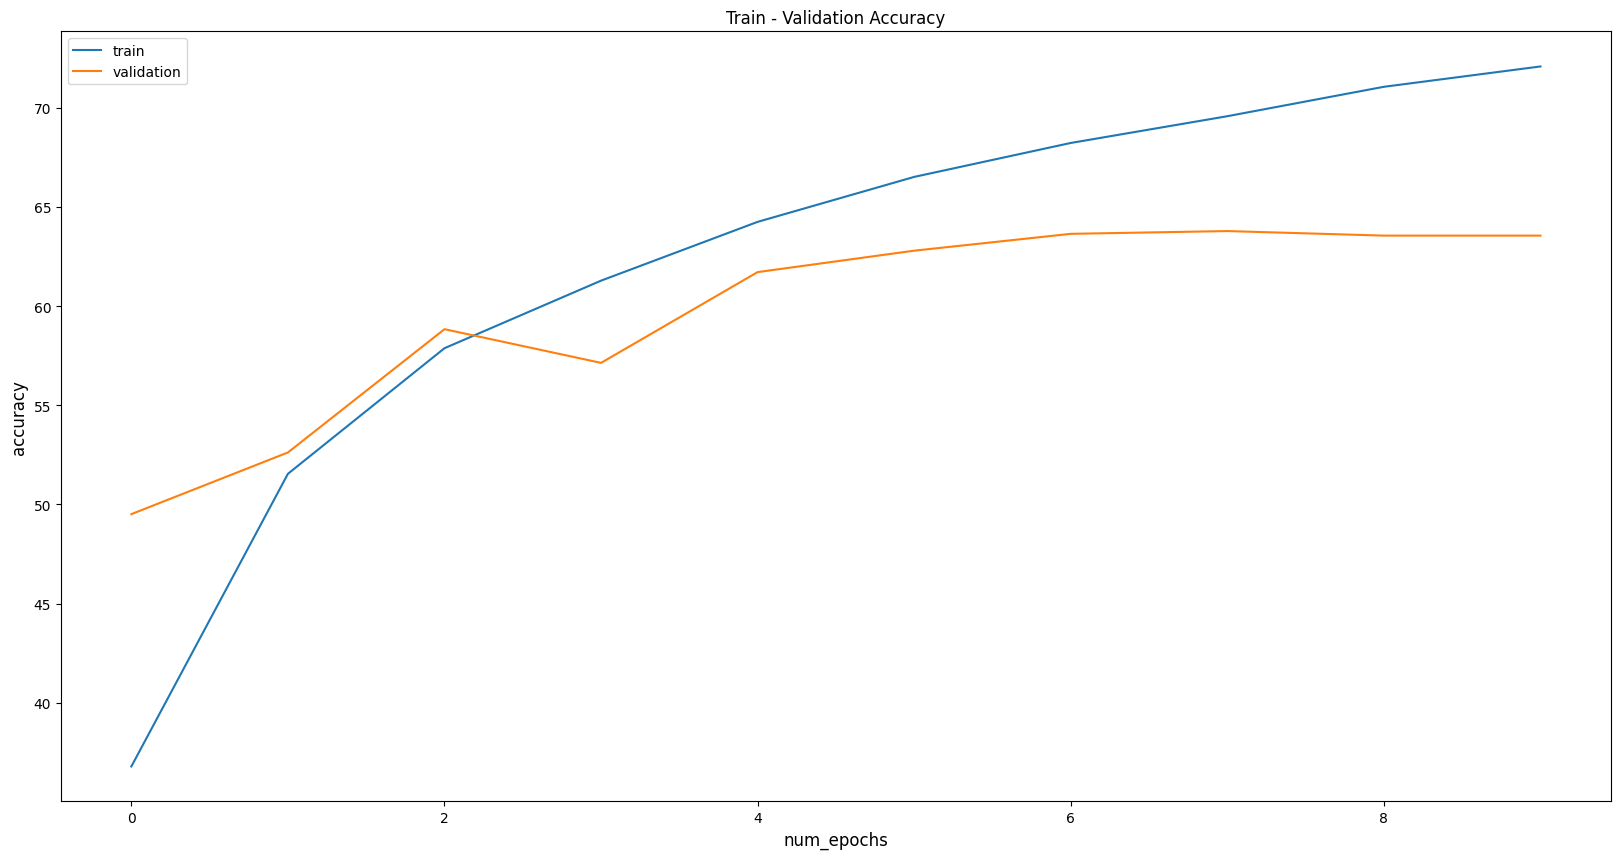

In [6]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

###7. Plot the confusion matrix

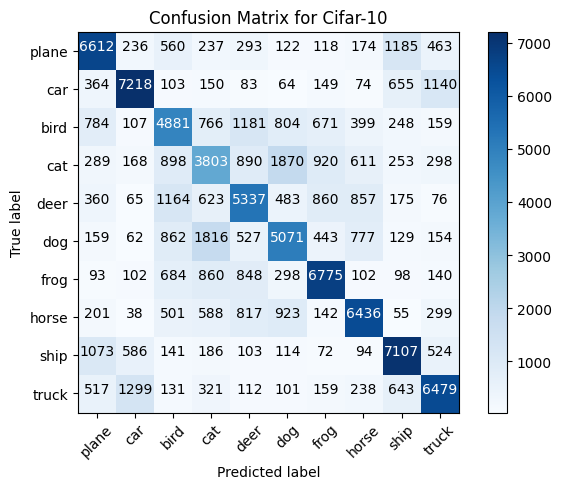

In [7]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Cifar-10")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()